## Logistic Regression Model: Predicting High vs. Low Amazon Reviews (2023–2024)

Binary classification model using TF-IDF text features, VADER sentiment scores, and review metadata. Neutral reviews (rating = 3) are excluded. Threshold tuned to improve performance on the minority “high” class.

In [2]:
# Reading the data and splitting columns

import pandas as pd
df = pd.read_csv(
    "Amazon_Reviews.csv",
    engine="python",
    on_bad_lines="warn"
)
df[['year_posted', 'month_posted', 'daytime_posted']] = df['Review Date'].str.split('-', expand=True)
df[['month_ex', 'day_ex','year_ex']] = df['Date of Experience'].str.split(' ', expand=True)
df[['review count', 'extra']] = df['Review Count'].str.split(' ', expand=True)
df['rating'] = df['Rating'].str.split().str[1]
df['rating'] = pd.to_numeric(df['rating'], errors = "coerce")
df['review count'] = pd.to_numeric(df['review count'], errors = "coerce")
df["year_posted"] = pd.to_numeric(df["year_posted"], errors="coerce")
df["month_posted"] = pd.to_numeric(df["month_posted"], errors="coerce")

In [3]:
# Cleaning data based on analysis plan

import numpy as np

# 1) Select relevant columns
clean_df = df[[
    'Country',
    'Review Text',
    'year_posted',
    'month_posted',
    'month_ex',
    'year_ex',
    'review count',
    'rating'
]].copy()


# 2) Drop rows where rating or year couldn't be parsed
clean_df = clean_df.dropna(subset=["year_posted", "rating"])

# 3) Filter to 2023–2024 and remove neutral ratings (3)

clean_df = clean_df[
    clean_df["year_posted"].isin([2023, 2024])
]

clean_df = clean_df[
    clean_df["rating"] != 3
]

# 4) Create binary target variable (high = 1, low = 0)
clean_df["rating_binary"] = (clean_df["rating"] >= 4).astype(int)

# 5) Drop rows with missing review text (for modeling)

model_df = clean_df.dropna(subset=["Review Text"]).copy()

#  6) Fill missing numeric values with medians
for col in ["month_posted", "review count"]:
    model_df[col] = model_df[col].fillna(model_df[col].median())

#  7) Keep top 5 most frequent countries and group the rest as "Other"
top_countries = model_df["Country"].value_counts().nlargest(5).index
model_df["Country_grouped"] = model_df["Country"].where(model_df["Country"].isin(top_countries), "Other")

model_df.head()

model_df.to_csv("final_cleaned_dataset.csv", index=False)


In [4]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.0 MB/s eta 0:00:00


In [22]:
# Text + Sentiment + Metadata Logistic Regression (High vs Low)
# Goal: Predict if a review gives a "high" (4-5) or "low" (1-2) rating by:
#  - using TF-IDF features from review text
#  - adding VADER sentiment scores as extra numeric features
#  - using class_weight="balanced" to account for imbalance
#  - tuning the probability threshold for the "high" minority class

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


# 1) Create VADER sentiment features
# VADER provides 4 scores:
#   compound (overall), pos, neu, neg
analyzer = SentimentIntensityAnalyzer()

def vader_scores(text: str) -> pd.Series:
    """Return VADER sentiment scores for a given text."""
    scores = analyzer.polarity_scores(str(text))
    return pd.Series(
        [scores["compound"], scores["pos"], scores["neu"], scores["neg"]],
        index=["sent_compound", "sent_pos", "sent_neu", "sent_neg"]
    )

# Apply VADER to each review text
model_df[["sent_compound", "sent_pos", "sent_neu", "sent_neg"]] = (
    model_df["Review Text"].apply(vader_scores)
)


# 2) Build feature matrix X and label y
# We feed:
#   - raw text into TF-IDF
#   - numeric features through StandardScaler
#   - categorical country through OneHotEncoder
feature_cols = [
    "Review Text",
    "Country_grouped",
    "review count",
    "month_posted",
    "sent_compound", "sent_pos", "sent_neu", "sent_neg"
]

X = model_df[feature_cols].copy()
y = model_df["rating_binary"].astype(int)


# 3) Train / test split (stratified)
# Stratify keeps the high/low proportion similar in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 4) Preprocessing + model pipeline
# ColumnTransformer lets us apply different preprocessing to different columns:
#  - TF-IDF on "Review Text"
#  - scaling for numeric features
#  - one-hot encoding for country
preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            stop_words="english",
            ngram_range=(1, 2),
            max_features=8000,
            min_df=2
        ), "Review Text"),

        ("num", StandardScaler(), [
            "review count", "month_posted",
            "sent_compound", "sent_pos", "sent_neu", "sent_neg"
        ]),

        ("cat", OneHotEncoder(handle_unknown="ignore"), ["Country_grouped"]),
    ],
    remainder="drop"
)

# Logistic Regression:
# - class_weight="balanced" increases penalty on minority class errors
# - saga solver handles sparse TF-IDF well
clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("lr", LogisticRegression(
        max_iter=3000,
        solver="saga",
        class_weight="balanced",
        n_jobs=-1
    ))
])

# Train model
clf.fit(X_train, y_train)


# 5) Threshold tuning (optimize F1 for HIGH class)
# By default, predict() uses threshold = 0.50 for class 1.
# For imbalanced classification, adjusting the threshold can
# improve the "high" class metrics (precision/recall tradeoff).
probs = clf.predict_proba(X_test)[:, 1]  # probability of class 1 ("high")

thresholds = np.arange(0.20, 0.91, 0.01)
best_t = 0.50
best_f1 = -1.0

for t in thresholds:
    preds = (probs >= t).astype(int)
    f1_high = f1_score(y_test, preds, pos_label=1)
    if f1_high > best_f1:
        best_f1 = f1_high
        best_t = t

final_preds = (probs >= best_t).astype(int)

# 6) Evaluation
print(f"Best threshold for HIGH (by F1): {best_t:.2f}\n")

print("High accuracy: ", accuracy_score(y_test, final_preds))
print("High precision:", precision_score(y_test, final_preds, pos_label=1))
print("High recall:   ", recall_score(y_test, final_preds, pos_label=1))
print("High F1:       ", f1_score(y_test, final_preds, pos_label=1))

print("\nClassification report:")
print(classification_report(y_test, final_preds, target_names=["low (0)", "high (1)"]))


# 7) Feature importance
import matplotlib.pyplot as plt

# Non-text features

# Extract trained logistic regression
lr_model = clf.named_steps["lr"]

# Get numeric feature names (in order used in ColumnTransformer)
num_features = ["review count", "month_posted",
                "sent_compound", "sent_pos",
                "sent_neu", "sent_neg"]

# Get country dummy names
cat_features = clf.named_steps["preprocess"] \
    .named_transformers_["cat"] \
    .get_feature_names_out(["Country_grouped"])

# Combine only non-text features
selected_features = np.concatenate([num_features, cat_features])

# Extract coefficients corresponding ONLY to numeric + categorical
text_feature_count = len(
    clf.named_steps["preprocess"]
    .named_transformers_["text"]
    .get_feature_names_out()
)

# Coefficients for non-text features
coefs_non_text = lr_model.coef_[0][text_feature_count:]

importance_df = pd.DataFrame({
    "Feature": selected_features,
    "Coefficient": coefs_non_text,
    "Abs_Coefficient": np.abs(coefs_non_text)
}).sort_values("Abs_Coefficient", ascending=False)

importance_df




Best threshold for HIGH (by F1): 0.70

High accuracy:  0.9467680608365019
High precision: 0.8154761904761905
High recall:    0.7784090909090909
High F1:        0.7965116279069767

Classification report:
              precision    recall  f1-score   support

     low (0)       0.97      0.97      0.97      1139
    high (1)       0.82      0.78      0.80       176

    accuracy                           0.95      1315
   macro avg       0.89      0.88      0.88      1315
weighted avg       0.95      0.95      0.95      1315



,Feature,Coefficient,Abs_Coefficient
3,sent_pos,0.941808,0.941808
5,sent_neg,-0.894695,0.894695
6,Country_grouped_CA,-0.835954,0.835954
7,Country_grouped_GB,-0.830942,0.830942
11,Country_grouped_US,-0.775365,0.775365
9,Country_grouped_NL,-0.653205,0.653205
10,Country_grouped_Other,-0.293099,0.293099
2,sent_compound,0.253928,0.253928
4,sent_neu,-0.150881,0.150881
8,Country_grouped_IN,-0.110114,0.110114


In [23]:
# Text/Word-Level Feature Importance (TF-IDF Features)

# Extract trained logistic regression
lr_model = clf.named_steps["lr"]

# Extract TF-IDF feature names
tfidf_feature_names = clf.named_steps["preprocess"] \
    .named_transformers_["text"] \
    .get_feature_names_out()

# Extract coefficients
coefs = lr_model.coef_[0]

# Number of TF-IDF features
n_text_features = len(tfidf_feature_names)

# Coefficients corresponding only to TF-IDF words
text_coefs = coefs[:n_text_features]

# Create importance dataframe
word_importance = pd.DataFrame({
    "Word": tfidf_feature_names,
    "Coefficient": text_coefs,
    "Abs_Coefficient": np.abs(text_coefs)
}).sort_values("Abs_Coefficient", ascending=False)

# Top 20 most influential words (absolute magnitude)
top_words = word_importance.head(20)

top_words


,Word,Coefficient,Abs_Coefficient
2949,fast,3.066736,3.066736
5350,problem,3.059737,3.059737
263,account,-3.001936,3.001936
3242,good,2.957866,2.957866
455,amazon,-2.954738,2.954738
5360,problems,2.858042,2.858042
3733,issues,2.787541,2.787541
3304,great,2.744469,2.744469
5530,quickly,2.676010,2.676010
2829,excellent,2.630939,2.630939


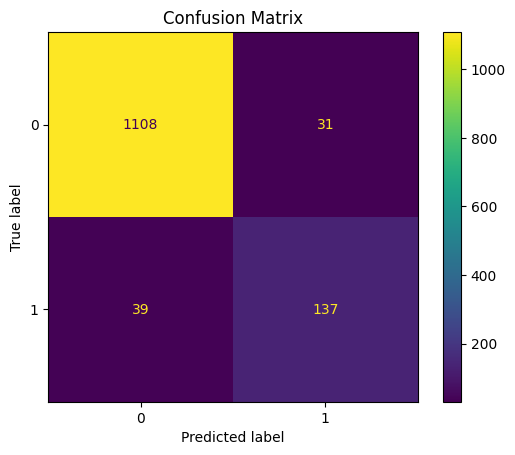

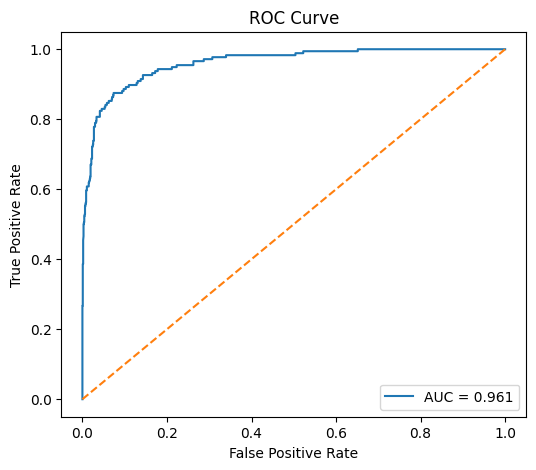

In [24]:

# Visualizations for Model Evaluation

from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Confusion Matrix

ConfusionMatrixDisplay.from_predictions(y_test, final_preds)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve + AUC

fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


